In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 29 15:00:32 2024

@author: Arran
"""


# __all__ = ['kappavalue']
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import astropy.units as u
from astropy.coordinates import SkyCoord, SpectralCoord
from astropy.wcs.utils import wcs_to_celestial_frame
import eispac

from astropy.visualization import astropy_mpl_style
from astropy.io import fits


#importing tools to define a kappa fit
from numpy import exp, linspace, random
from scipy.optimize import curve_fit

plt.style.use(astropy_mpl_style)


#define kappavalue to read into fittingfunctions.py
# kappavalue = 1

In [25]:
###Template parser to parse template data values and pass into fitting functions###
def templateparser(tmplt):
    pvallst = []
    plimslst = []
    for i in range(len(tmplt.parinfo)):
        pvallst.append(tmplt.parinfo[i]['value'])
        plimslst.append(tmplt.parinfo[i]['limits'])
        
    return pvallst, plimslst

###Defining the Kappa distribution function for fitting### 
def kappafunc(x, amp, cen, wid, kappa):
    #defining the variance-like variable indicated in Jeffreys. N. S et al (2016)
    variance_k = wid * (1 - 3/(2*kappa))
    #argument used in kappa function 
    arg = (1 + ((x - cen)**2)/(2 * (variance_k**2) * kappa))
    
    return amp * (arg) ** (-1 *kappa)

###defining kappafit for scipy curvefit###
#last arg for defining initial kappa guess when calling in the func
def kfitter(x, y, tmplt, kappinit):
    #parameter values
    pval = templateparser(tmplt)[0]
    #parameter limits
    plims = templateparser(tmplt)[1]
    #initial values for curve fits, inital kappa guess at end
    init_val = [pval[0], pval[1], pval[2], kappinit]
    
    # bounds=([0., plims[1][0] ,plims[2][0], 0.], [1e100, plims[1][1], plims[2][1], 1000])
    
    #original curvefit vals w/ bounds
    best_vals, covar = curve_fit(kappafunc, x, y, p0=init_val, bounds=([0., plims[1][0] ,plims[2][0], 0.], [1e100, plims[1][1], plims[2][1], 1000]), max_nfev=10000)
    
    return best_vals, covar

In [3]:
if __name__ == '__main__':
    # Read in the fit template and EIS observation
    data_filepath = './eis_20170906_120233.data.h5'
    
    
    #testing template fitting for both lines
    
    # tmplt = eispac.EISFitTemplate(value=[ 19253.7287, 262.9824, 0.0341, 118.9812, 1601.5393,263.7539,0.0649, 342.9053], line_ids=['Fe XVI 262.984', 'Fe XXIII 263.760' ], wmin=262.78399658203125, wmax= 263.96002197265625)

    #original tmplt fit
    template_filepath1 = './fe_16_262_984.1c.template.h5'
    template_filepath2 = './fe_23_263_760.1c.template.h5'
    
    tmplt1 = eispac.read_template(template_filepath1)
    tmplt2 = eispac.read_template(template_filepath2)
    #
    data_cube1 = eispac.read_cube(data_filepath, tmplt1.central_wave)
    data_cube2 = eispac.read_cube(data_filepath, tmplt2.central_wave)
    
    # Select a cutout of the raster
    eis_frame = wcs_to_celestial_frame(data_cube1.wcs)
    print(eis_frame)
    lower_left = [None, SkyCoord(Tx=540, Ty=-240, unit=u.arcsec, frame=eis_frame)]
    print(lower_left)
    upper_right = [None, SkyCoord(Tx=560, Ty=-220, unit=u.arcsec, frame=eis_frame)]
    
    
    # #original cutout for cropping
    # raster_cutout1 = data_cube1.crop(lower_left, upper_right)
    # raster_cutout2 = data_cube2.crop(lower_left, upper_right)
    
    
    #raster 'cutout' change to entire observation
    raster_cutout1 = data_cube1
    raster_cutout2 = data_cube2
    

length of params 4
length of params 4
Data file,
   C:\Users\Owner\Documents\Course Material\MSc\Project\CatalogTest\data_eis\eis_20170906_120233.data.h5
Header file,
   C:\Users\Owner\Documents\Course Material\MSc\Project\CatalogTest\data_eis\eis_20170906_120233.head.h5
Found a wavelength 262.94 [Angstroms] in window 4
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   C:\Users\Owner\Documents\Course Material\MSc\Project\CatalogTest\data_eis\eis_20170906_120233.data.h5
Header file,
   C:\Users\Owner\Documents\Course Material\MSc\Project\CatalogTest\data_eis\eis_20170906_120233.head.h5
Found a wavelength 263.71 [Angstroms] in window 4
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 7.24812458, 1.50773899e+11)>)>
[None, <SkyCoord (He

EISPAC FITTING

In [4]:
    # # Fit the data and save it to disk
    fit_res1 = eispac.fit_spectraKAPPA(raster_cutout1, tmplt1, ncpu='max')
    save_filepaths1 = eispac.save_fit(fit_res1, save_dir='cwd')
    
    
    fit_res2 = eispac.fit_spectraKAPPA(raster_cutout2, tmplt2, ncpu='max')
    save_filepaths2 = eispac.save_fit(fit_res2, save_dir='cwd')
    

length of params 4
 + computing fits for 30 exposures, each with 120 spectra
 + running mpfit on 4 cores (of 4)


Finished computing fits!
   runtime : 0:00:44.716672
   3600 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: C:\Users\Owner\Documents\Course Material\MSc\Project\CatalogTest\data_eis
   Filenames: eis_20170906_120233.fe_16_262_984.1c-0.fit.h5
length of params 4
 + computing fits for 30 exposures, each with 120 spectra
 + running mpfit on 4 cores (of 4)


Finished computing fits!
   runtime : 0:00:46.586663
   3600 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: C:\Users\Owner\Documents\Course Material\MSc\Project\CatalogTest\data_eis
   Filenames: eis_20170906_120233.fe_23_263_760.1c-0.fit.h5


In [5]:
    
    # # Find indices and world coordinates of max intensity
    sum_data_inten1 = raster_cutout1.sum_spectra().data
    sum_data_fullregion1 = data_cube1.sum_spectra().data  #use for full region image on subplot?
    sum_data_inten2 = raster_cutout2.sum_spectra().data
    sum_data_fullregion2 = data_cube2.sum_spectra().data  #use for full region image on subplot?

    def worldtoindex(raster, xarc, yarc):
        indexcoord = raster.wcs.world_to_array_index(SpectralCoord(2.627245243818844e-08, unit = u.m ), SkyCoord(Tx=xarc, Ty=yarc, unit=u.arcsec, frame=eis_frame))
        iy, ix = indexcoord[0], indexcoord[1]
        return iy, ix

    # print(worldtoindex(raster_cutout1, 550, -240)[0])
        
    coordx = np.linspace(540,600,10)
    coordy = np.linspace(-240,-160,10)

    xv, yv = np.meshgrid(coordx, coordy)
    print(xv, yv)

    
    xindex = []
    yindex = []
    for i in range(len(coordx)):
        # xindex.append(worldtoindex(raster_cutout1, coordx[i], coordy[i])[0])
        # yindex.append(worldtoindex(raster_cutout1, coordx[i], coordy[i])[1])
        xindex.append(worldtoindex(raster_cutout1, xv[i], yv[i])[0])
        yindex.append(worldtoindex(raster_cutout1, xv[i], yv[i])[1])
    print(xindex)
    print(yindex)


        
        
    # iy, ix = np.unravel_index(sum_data_inten1.argmax(), sum_data_inten1.shape)
    iy, ix = worldtoindex(raster_cutout1, 550, -225)[0], worldtoindex(raster_cutout1, 550, -225)[1]
    worldcoord = raster_cutout1.wcs.array_index_to_world(iy, ix, 0)
    # indexcoord = raster_cutout1.wcs.world_to_array_index(SpectralCoord(2.627245243818844e-08, unit = u.m ), SkyCoord(Tx=550, Ty=-226, unit=u.arcsec, frame=eis_frame))
    print(iy, ix)
    print(worldcoord)
    # print(indexcoord)
    

[[540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         566.66666667
  573.33333333 580.         586.66666667 593.33333333 600.        ]
 [540.         546.66666667 553.33333333 560.         5

[[20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [29, 29, 29, 29, 29, 29, 29, 29, 29, 29], [38, 38, 38, 38, 38, 38, 38, 38, 38, 38], [47, 47, 47, 47, 47, 47, 47, 47, 47, 47], [56, 56, 56, 56, 56, 56, 56, 56, 56, 56], [65, 65, 65, 65, 65, 65, 65, 65, 65, 65], [74, 74, 74, 74, 74, 74, 74, 74, 74, 74], [83, 83, 83, 83, 83, 83, 83, 83, 83, 83], [91, 91, 91, 91, 91, 91, 91, 91, 91, 91], [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]]
[[10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25], [10, 12, 14, 15, 17, 19, 20, 22, 24, 25]]
35 13
[<SpectralCoord 2.62724524e-08 m>, <SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (ob

In [6]:
    # iy, ix = np.unravel_index(np.argsort(sum_data_inten1.ravel(), axis=0)[-30], sum_data_inten1.shape)
    
    
    ex_world_coords1 = raster_cutout1.wcs.array_index_to_world(iy, ix, 0)[1]
    print(ex_world_coords1)
    ex_world_coords2 = raster_cutout2.wcs.array_index_to_world(iy, ix, 0)[1]
    
    
    # y_arcsec1, x_arcsec1 = ex_world_coords1.Ty.value, ex_world_coords1.Tx.value
    # y_arcsec2, x_arcsec2 = ex_world_coords2.Ty.value, ex_world_coords2.Tx.value
    
    y_arcsec, x_arcsec = ex_world_coords1.Ty.value, ex_world_coords1.Tx.value
    
    
    # print(y_arcsec1, y_arcsec2)
    # print(x_arcsec1, x_arcsec2)
    # print(ex_world_coords1,ex_world_coords2)
    
    
    # Extract data profile and interpolate fit at higher spectral resolution
    data_x1 = raster_cutout1.wavelength[iy, ix, :]
    data_y1 = raster_cutout1.data[iy, ix, :]
    data_err1 = raster_cutout1.uncertainty.array[iy, ix, :]
    fit_x1, fit_y1 = fit_res1.get_fit_profile(coords=[iy,ix], num_wavelengths=100)
    chi2fit1 = fit_res1.fit['chi2'][iy,ix]
    print(chi2fit1)
    c0_x1, c0_y1 = fit_res1.get_fit_profile(0, coords=[iy,ix], num_wavelengths=100)
    
    data_x2 = raster_cutout2.wavelength[iy, ix, :]
    data_y2 = raster_cutout2.data[iy, ix, :]
    data_err2 = raster_cutout2.uncertainty.array[iy, ix, :]
    fit_x2, fit_y2 = fit_res2.get_fit_profile(coords=[iy,ix], num_wavelengths=100)
    chi2fit2 = fit_res2.fit['chi2'][iy,ix]
    print(chi2fit2)
    c0_x2, c0_y2 = fit_res2.get_fit_profile(0, coords=[iy,ix], num_wavelengths=100)
    
    

<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 7.24812458, 1.50773899e+11)>): (Tx, Ty) in arcsec
    (551.02564815, -225.35904776)>
0.22045880196199139
0.30651821920340605


In [27]:
        
    
    ####### test section for scipy kappa fitting #######
    
    print("Fe16 bestfits scipy \n", kfitter(data_x1, data_y1, tmplt1, 5)[0])
    print("Fe23 bestfits scipy \n", kfitter(data_x2, data_y2, tmplt2, 5)[0])


    # fig = plt.figure()
    # plt.plot(data_x1, kappafunc(data_x1, *kfitter(data_x1, data_y1, tmplt1, 400)[0]))
    # # plt.plot(data_x2, kappafunc(data_x2, *kfitter(data_x2, data_y2, tmplt2, 100)[0]))
    # plt.plot(data_x2, kappafunc(data_x2, 3.45127518e+04, 2.63753929e+02, 6.48928715e-02, 1000 ))
    # plt.scatter(data_x1, data_y1, marker='o')
    
    ####################################################

                                         
    # c1_x, c1_y = fit_res.get_fit_profile(1, coords=[iy,ix], num_wavelengths=100)
    # c2_x, c2_y = fit_res.get_fit_profile(2, coords=[iy,ix], num_wavelengths=100)

Fe16 bestfits scipy 
 [2.50987561e+04 2.62982434e+02 3.41032237e-02 5.00000000e+00]
Fe23 bestfits scipy 
 [1.75541648e+04 2.63753929e+02 6.48928715e-02 5.00000000e+00]


Text(0, 0.5, 'Solar-Y [arcsec]')

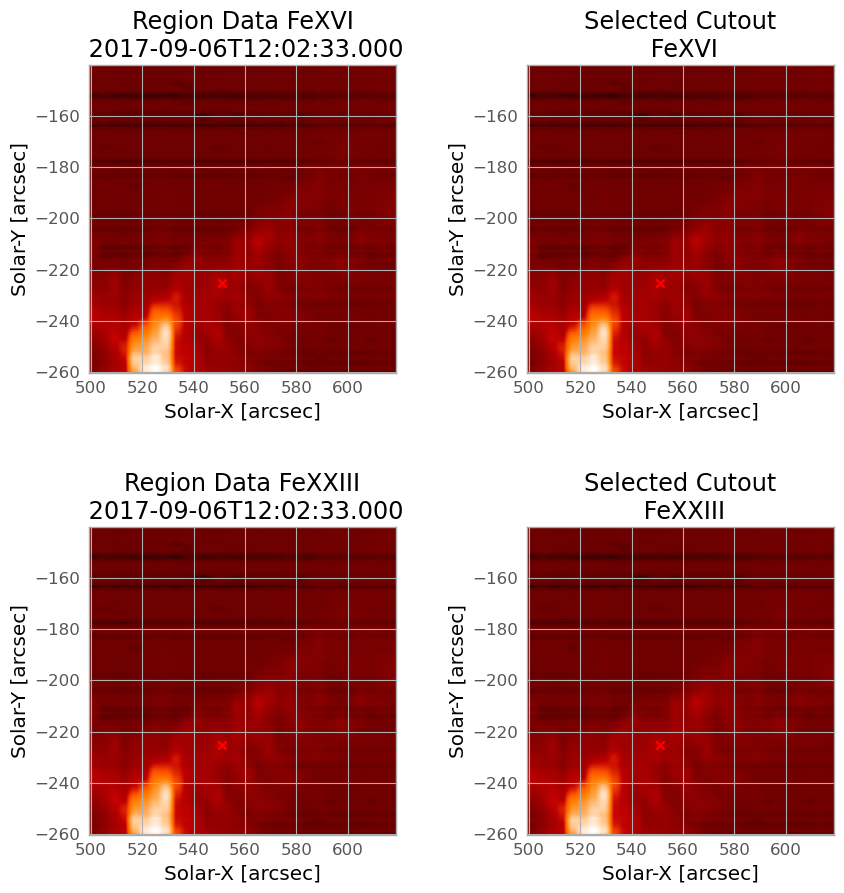

In [8]:
    # Make a multi-panel figure with the cutout and example profile
    
    
    
    import matplotlib.gridspec as gridspec
    
    # fig = plt.figure(figsize=[10,5])
    # plot_grid = fig.add_gridspec(nrows=2, ncols=4, wspace=0.3)
    
    #####First Figure window for intensity and cutout#####
    fig = plt.figure(figsize=[10,10])
    
    
    
    plot_grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.3)
    
    
    # data_subplt = fig.add_subplot(plot_grid[0,0])
    # data_subplt.imshow(sum_data_inten, origin='lower', extent = data_cube.meta['extent_arcsec'])
    data_subplt = fig.add_subplot(plot_grid[0,0])
    data_subplt.scatter(x_arcsec, y_arcsec, color='r', marker='x')
    # data_subplt.imshow(sum_data_inten, origin='lower', extent = data_cube.meta['extent_arcsec'])
    data_subplt.imshow(sum_data_fullregion1, norm=colors.PowerNorm(gamma=0.2) ,origin='lower', extent = data_cube1.meta['extent_arcsec'])
    data_subplt.set_title('Region Data FeXVI\n'+' ' +raster_cutout1.meta['mod_index']['date_obs'])
    data_subplt.set_xlabel('Solar-X [arcsec]')
    data_subplt.set_ylabel('Solar-Y [arcsec]')
    
    data_subplt = fig.add_subplot(plot_grid[0,1])
    data_subplt.scatter(x_arcsec, y_arcsec, color='r', marker='x')
    # data_subplt.imshow(sum_data_inten, origin='lower', extent = data_cube.meta['extent_arcsec'])
    data_subplt.imshow(sum_data_inten1, norm=colors.PowerNorm(gamma=0.2) , origin='lower', extent = raster_cutout1.meta['extent_arcsec'])
    data_subplt.set_title('Selected Cutout\n FeXVI')
    data_subplt.set_xlabel('Solar-X [arcsec]')
    data_subplt.set_ylabel('Solar-Y [arcsec]')
    
    
    
    data_subplt = fig.add_subplot(plot_grid[1,0])
    data_subplt.scatter(x_arcsec, y_arcsec, color='r', marker='x')
    # data_subplt.imshow(sum_data_inten, origin='lower', extent = data_cube.meta['extent_arcsec'])
    data_subplt.imshow(sum_data_fullregion2, norm=colors.PowerNorm(gamma=0.2) ,origin='lower', extent = data_cube2.meta['extent_arcsec'])
    data_subplt.set_title('Region Data FeXXIII\n'+' ' +raster_cutout2.meta['mod_index']['date_obs'])
    data_subplt.set_xlabel('Solar-X [arcsec]')
    data_subplt.set_ylabel('Solar-Y [arcsec]')
    
    data_subplt = fig.add_subplot(plot_grid[1,1])
    data_subplt.scatter(x_arcsec, y_arcsec, color='r', marker='x')
    # data_subplt.imshow(sum_data_inten, origin='lower', extent = data_cube.meta['extent_arcsec'])
    data_subplt.imshow(sum_data_inten2, norm=colors.PowerNorm(gamma=0.2) , origin='lower', extent = raster_cutout2.meta['extent_arcsec'])
    data_subplt.set_title('Selected Cutout\n FeXXIII')
    data_subplt.set_xlabel('Solar-X [arcsec]')
    data_subplt.set_ylabel('Solar-Y [arcsec]')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Text(0.5, 0, 'Wavelength [$\\AA$]')

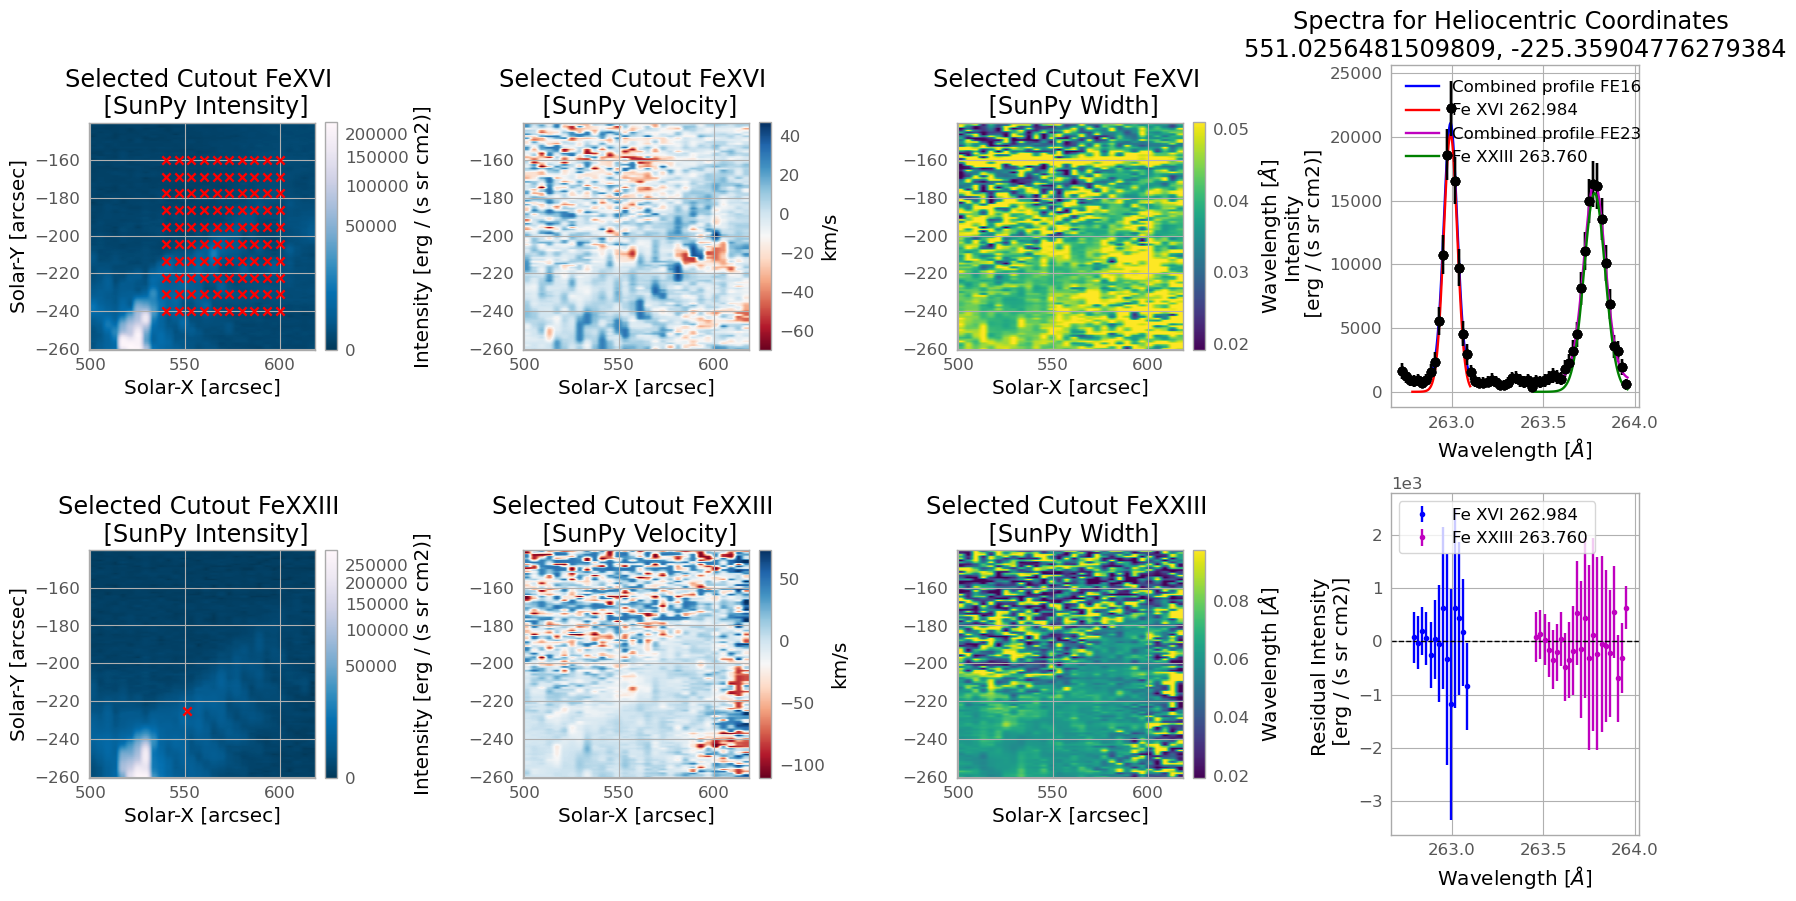

In [9]:
    #####2nd Figure window for intensity, vel, width, and spectra#####


        #2nd Figure window for intensity, vel, width, and spectra
    from matplotlib.gridspec import SubplotSpec

    fig = plt.figure(figsize=[20,10])
    plot_grid = fig.add_gridspec(nrows=2, ncols=4, wspace=0.75, hspace = 0.25)
    


    #Subplots for Fe16

    data_subplt = fig.add_subplot(plot_grid[0,0])
    inten_map = fit_res1.get_map(component=0, measurement='intensity')
    #sunpy measurement map can be used in matplotlib subplt using .imshow by including .data at the end of our maps (e.g inten_map.data)
    data_subplt.imshow(inten_map.data, norm=colors.PowerNorm(gamma=0.4) , origin='lower', extent = raster_cutout1.meta['extent_arcsec'], cmap='PuBu_r')
    #define position for subplt colourbar
    pos1 = data_subplt.imshow(inten_map.data, norm=colors.PowerNorm(gamma=0.4) , origin='lower', extent = raster_cutout1.meta['extent_arcsec'], cmap='PuBu_r')
    
    #data_subplt.scatter(x_arcsec, y_arcsec, color='r', marker='x')
    # for i in range(len(coordx)):
    #     for j in range(len(coordy)):
    #         data_subplt.scatter(coordx[i], coordy[j], color='r', marker='x')

    for i in range(len(xv)):
        data_subplt.scatter(xv[i], yv[i], color='r', marker='x')
    
    data_subplt.set_title('Selected Cutout FeXVI \n [SunPy Intensity]')
#Insert fraction=0.046, pad=0.04 to scale the colorbars appropriately
    fig.colorbar(pos1, fraction=0.046, pad=0.04, label = 'Intensity [erg / (s sr cm2)]')

    data_subplt.set_xlabel('Solar-X [arcsec]')
    data_subplt.set_ylabel('Solar-Y [arcsec]')
    
    data_subplt = fig.add_subplot(plot_grid[0,1])
    vel_map = fit_res1.get_map(component=0, measurement='vel')
    #sunpy measurement map can be used in matplotlib subplt using .imshow by including .data at the end of our maps (e.g inten_map.data)
    data_subplt.imshow(vel_map.data,origin='lower', extent = raster_cutout1.meta['extent_arcsec'], cmap = 'RdBu')
    #define position for subplt colourbar
    pos2 = data_subplt.imshow(vel_map.data,origin='lower', extent = raster_cutout1.meta['extent_arcsec'], cmap = 'RdBu')
    data_subplt.set_title('Selected Cutout FeXVI \n [SunPy Velocity]')
    fig.colorbar(pos2, fraction=0.046, pad=0.04, label = 'km/s')

    data_subplt.set_xlabel('Solar-X [arcsec]')
    
    data_subplt = fig.add_subplot(plot_grid[0,2])
    width_map = fit_res1.get_map(component=0, measurement='width')
    #sunpy measurement map can be used in matplotlib subplt using .imshow by including .data at the end of our maps (e.g inten_map.data)
    data_subplt.imshow(width_map.data,origin='lower', extent = raster_cutout1.meta['extent_arcsec'], cmap = 'viridis')
    #define position for subplt colourbar
    pos3 = data_subplt.imshow(width_map.data,origin='lower', extent = raster_cutout1.meta['extent_arcsec'], cmap = 'viridis')
    data_subplt.set_title('Selected Cutout FeXVI \n [SunPy Width]')
    fig.colorbar(pos3,fraction=0.046, pad=0.04, label = 'Wavelength [$\AA$]')

    data_subplt.set_xlabel('Solar-X [arcsec]')



    #Subplots for Fe23

    data_subplt = fig.add_subplot(plot_grid[1,0])
    inten_map = fit_res2.get_map(component=0, measurement='intensity')
    #sunpy measurement map can be used in matplotlib subplt using .imshow by including .data at the end of our maps (e.g inten_map.data)
    data_subplt.imshow(inten_map.data, norm=colors.PowerNorm(gamma=0.4) , origin='lower', extent = raster_cutout2.meta['extent_arcsec'], cmap='PuBu_r')
    #define position for subplt colourbar
    pos4 = data_subplt.imshow(inten_map.data, norm=colors.PowerNorm(gamma=0.4) , origin='lower', extent = raster_cutout2.meta['extent_arcsec'], cmap='PuBu_r')
    data_subplt.scatter(x_arcsec, y_arcsec, color='r', marker='x')
    data_subplt.set_title('Selected Cutout FeXXIII \n [SunPy Intensity]')
#Insert fraction=0.046, pad=0.04 to scale the colorbars appropriately
    fig.colorbar(pos4, fraction=0.046, pad=0.04, label = 'Intensity [erg / (s sr cm2)]')

    data_subplt.set_xlabel('Solar-X [arcsec]')
    data_subplt.set_ylabel('Solar-Y [arcsec]')
    
    data_subplt = fig.add_subplot(plot_grid[1,1])
    vel_map = fit_res2.get_map(component=0, measurement='vel')
    #sunpy measurement map can be used in matplotlib subplt using .imshow by including .data at the end of our maps (e.g inten_map.data)
    data_subplt.imshow(vel_map.data,origin='lower', extent = raster_cutout2.meta['extent_arcsec'], cmap = 'RdBu')
    #define position for subplt colourbar
    pos5 = data_subplt.imshow(vel_map.data,origin='lower', extent = raster_cutout2.meta['extent_arcsec'], cmap = 'RdBu')
    data_subplt.set_title('Selected Cutout FeXXIII \n [SunPy Velocity]')
    fig.colorbar(pos5, fraction=0.046, pad=0.04, label = 'km/s')

    data_subplt.set_xlabel('Solar-X [arcsec]')
    
    data_subplt = fig.add_subplot(plot_grid[1,2])
    width_map = fit_res2.get_map(component=0, measurement='width')
    #sunpy measurement map can be used in matplotlib subplt using .imshow by including .data at the end of our maps (e.g inten_map.data)
    data_subplt.imshow(width_map.data,origin='lower', extent = raster_cutout2.meta['extent_arcsec'], cmap = 'viridis')
    #define position for subplt colourbar
    pos6 = data_subplt.imshow(width_map.data,origin='lower', extent = raster_cutout2.meta['extent_arcsec'], cmap = 'viridis')
    data_subplt.set_title('Selected Cutout FeXXIII \n [SunPy Width]')
    fig.colorbar(pos6,fraction=0.046, pad=0.04, label = 'Wavelength [$\AA$]')


    data_subplt.set_xlabel('Solar-X [arcsec]')

#plotting spectra FEXVI
    profile_subplt = fig.add_subplot(plot_grid[0,3])
    profile_subplt.errorbar(data_x1, data_y1, yerr=data_err1, ls='', marker='o', color='k')
    profile_subplt.plot(data_x1, data_y1, ls='', marker='o', color='k')
    profile_subplt.plot(fit_x1, fit_y1, color='b', label='Combined profile FE16')
    profile_subplt.plot(c0_x1, c0_y1, color='r', label=fit_res1.fit['line_ids'][0])
#plotting spectra FEXXIII
    profile_subplt.errorbar(data_x2, data_y2, yerr=data_err2, ls='', marker='o', color='k')
    profile_subplt.plot(data_x2, data_y2, ls='', marker='o', color='k')
    profile_subplt.plot(fit_x2, fit_y2, color='m', label='Combined profile FE23')
    profile_subplt.plot(c0_x2, c0_y2, color='g', label=fit_res2.fit['line_ids'][0])

    # profile_subplt.plot(c1_x, c1_y, color='r', ls='--', label=fit_res.fit['line_ids'][1])
    # profile_subplt.plot(c2_x, c2_y, color='g', label='Background')
    # profile_subplt.set_title(f'Cutout indices: iy = {iy}, ix = {ix}')
    profile_subplt.set_title('Spectra for Heliocentric Coordinates \n' f'{x_arcsec}, {y_arcsec}')
    profile_subplt.set_xlabel('Wavelength [$\AA$]')
    profile_subplt.set_ylabel('Intensity\n ['+raster_cutout1.unit.to_string()+']')
    profile_subplt.legend(loc='upper left', frameon=False)

    data_subplt.set_xlabel('Solar-X [arcsec]')

#Residuals plotting
    fit_x_vals1, fit_y_vals1 = fit_res1.get_fit_profile(coords=[iy,ix],use_mask=True) #use len(data_y) to get compatible array length for residuals, if necessary
    fit_x_vals2, fit_y_vals2 = fit_res2.get_fit_profile(coords=[iy,ix],use_mask=True) #use len(data_y) to get compatible array length for residuals, if necessary
   

# print(fit_x_vals)
    resids1 = fit_y_vals1 - data_y1
    resids2 = fit_y_vals2 - data_y2
    profile_subplt2 = fig.add_subplot(plot_grid[1,3], sharex= profile_subplt)
    
    plt.errorbar(x=fit_x_vals1, y=resids1, yerr=data_err1, fmt='.', color ='b', label=fit_res1.fit['line_ids'][0])
    plt.errorbar(x=fit_x_vals2, y=resids2, yerr=data_err2, fmt='.', color ='m', label=fit_res2.fit['line_ids'][0])
    plt.axhline(0.0, linestyle='--', color= 'black', linewidth=1)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.legend(loc='upper left')
    plt.ylabel('Residual Intensity \n [erg / (s sr cm2)]')
    plt.xlabel('Wavelength [$\AA$]')
    
    
    

[-- -- -- 76.30567994644832 -23.358313278763944 195.51212140317318
 57.58755902026064 -253.93099655407627 39.38549701858983
 -44.536804205668886 632.5835209493107 -337.4856935883836
 -1183.6735183633027 627.3055144552018 434.6179381831771
 167.66289208838862 -842.8576594580486 -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- --]
598.2197226668318


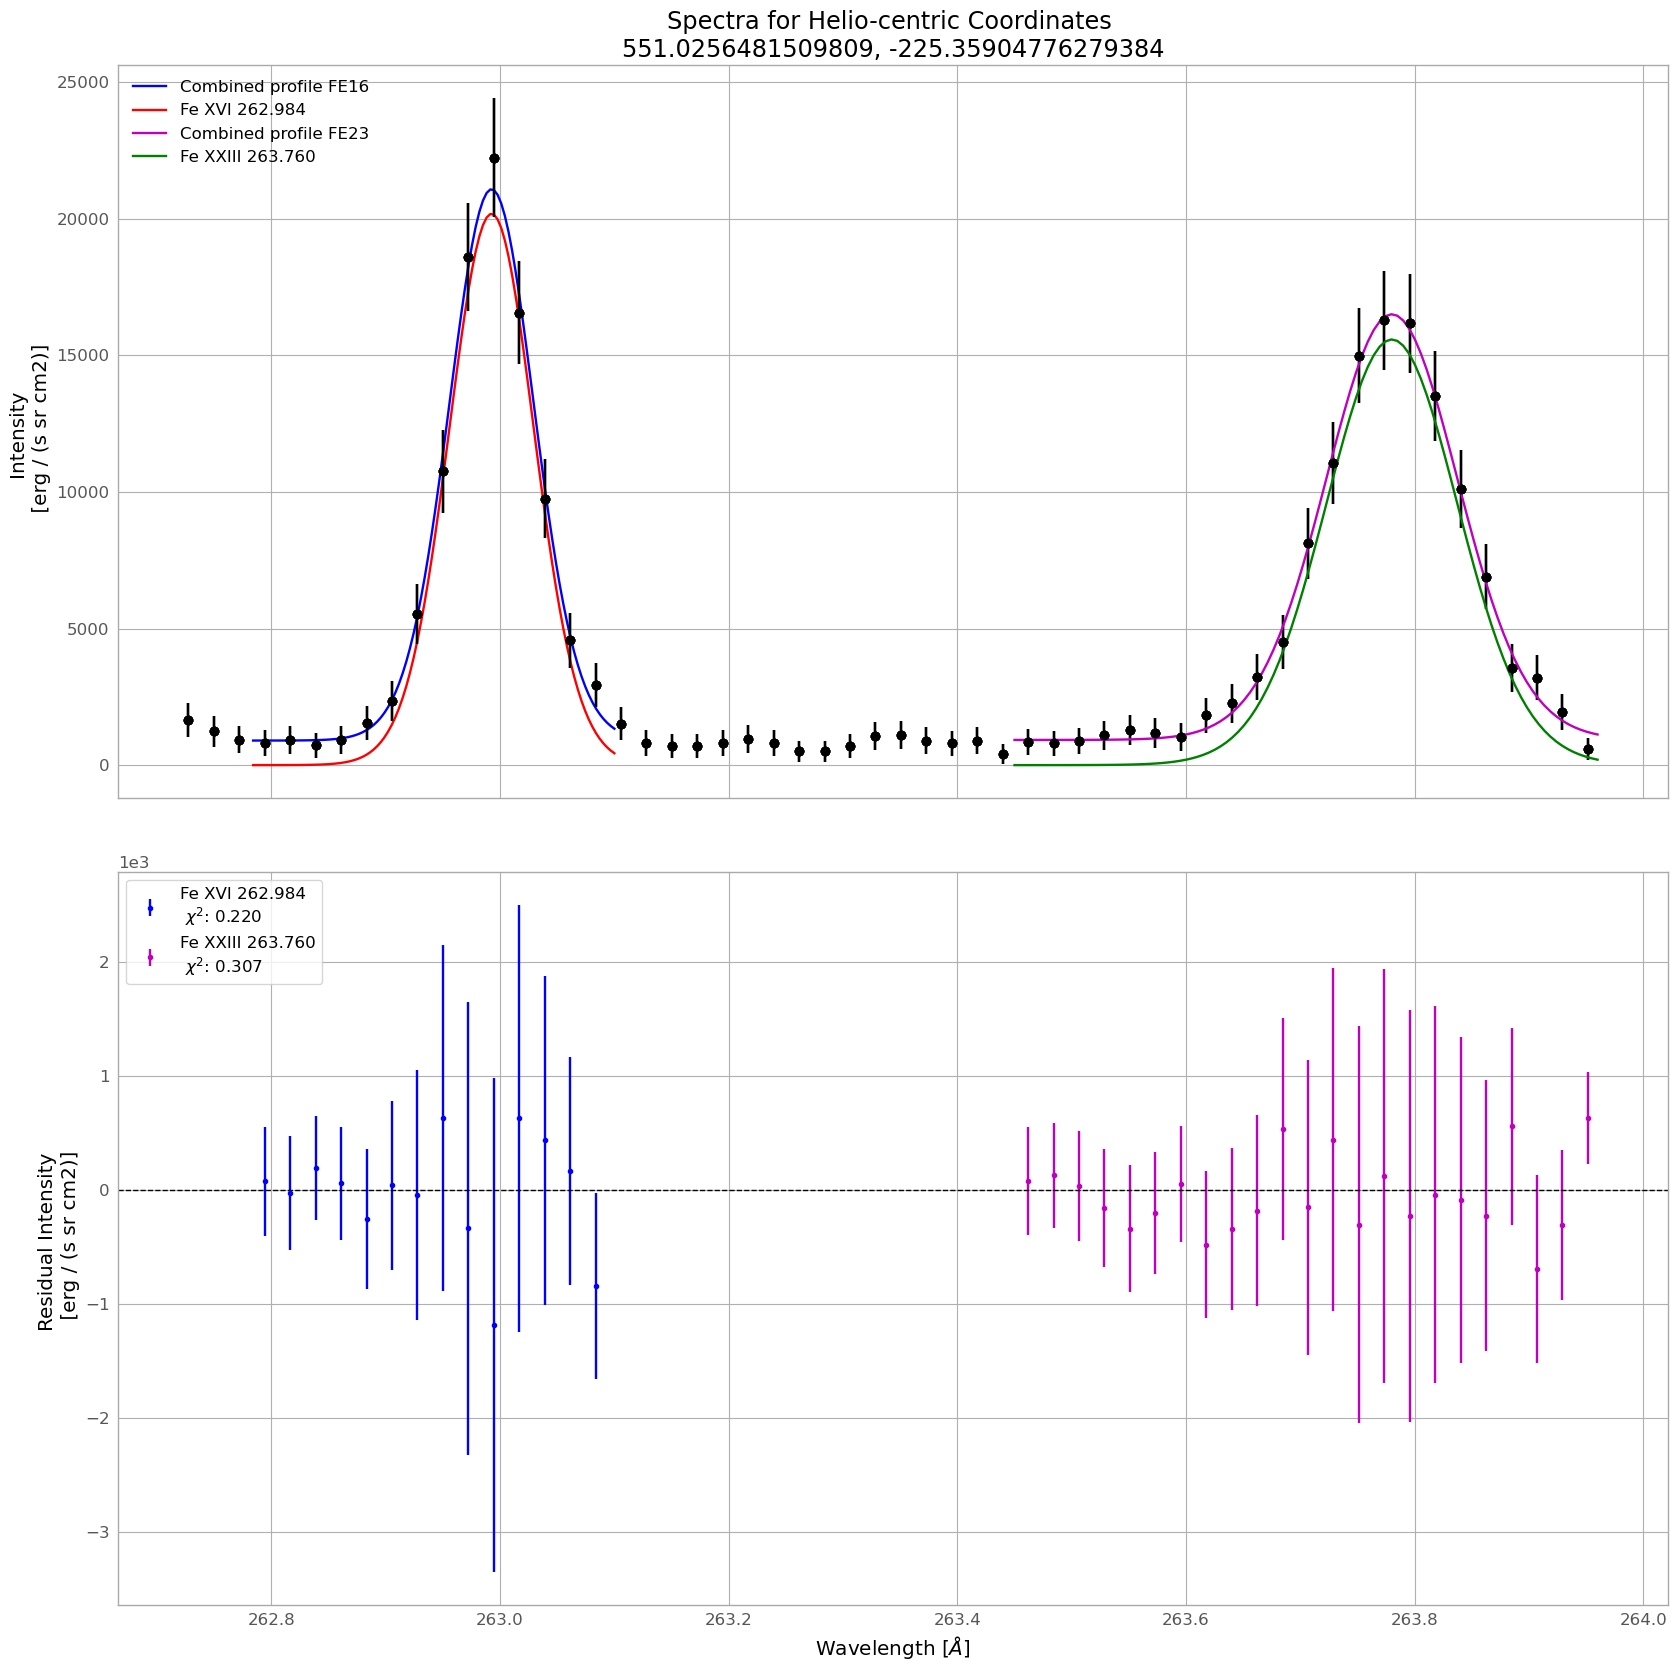

In [10]:
    #####3rd Fig Window for spectra and residuals only#####
     #3rd Fig Window for spectra and residuals only
    fig = plt.figure(figsize=[20,20])
    
    
    
    #Define values for residuals and plot spectra
    
    fit_x_vals1, fit_y_vals1 = fit_res1.get_fit_profile(coords=[iy,ix],use_mask=True) #use len(data_y) to get compatible array length for residuals, if necessary
    fit_x_vals2, fit_y_vals2 = fit_res2.get_fit_profile(coords=[iy,ix],use_mask=True) #use len(data_y) to get compatible array length for residuals, if necessary
    
    plot_grid = fig.add_gridspec(nrows=2, ncols=1, wspace=1, hspace=0.1)
    
    profile_subplt = fig.add_subplot(plot_grid[0,0])
    profile_subplt.errorbar(data_x1, data_y1, yerr=data_err1, ls='', marker='o', color='k')
    profile_subplt.plot(data_x1, data_y1, ls='', marker='o', color='k')
    profile_subplt.plot(fit_x1, fit_y1, color='b', label='Combined profile FE16')
    profile_subplt.plot(c0_x1, c0_y1, color='r', label=fit_res1.fit['line_ids'][0])
    #plotting spectra FEXXIII
    profile_subplt.errorbar(data_x2, data_y2, yerr=data_err2, ls='', marker='o', color='k')
    profile_subplt.plot(data_x2, data_y2, ls='', marker='o', color='k')
    profile_subplt.plot(fit_x2, fit_y2, color='m', label='Combined profile FE23')
    profile_subplt.plot(c0_x2, c0_y2, color='g', label=fit_res2.fit['line_ids'][0])
    
    # profile_subplt.plot(c1_x, c1_y, color='r', ls='--', label=fit_res.fit['line_ids'][1])
    # profile_subplt.plot(c2_x, c2_y, color='g', label='Background')
    # profile_subplt.set_title(f'Cutout indices: iy = {iy}, ix = {ix}')
    profile_subplt.set_title('Spectra for Helio-centric Coordinates \n' f'{x_arcsec}, {y_arcsec}')
    profile_subplt.set_xlabel('Wavelength [$\AA$]')
    profile_subplt.set_ylabel('Intensity \n ['+raster_cutout1.unit.to_string()+']')
    profile_subplt.legend(loc='upper left', frameon=False)
    
    # data_subplt.set_xlabel('Solar-X [arcsec]')
    # data_subplt.set_ylabel('Solar-Y [arcsec]')
    
    #Remove tick labels from upper spectra to 'blend' with residual plot
    profile_subplt.label_outer()
    
    
    
    #Set up and plot residuals
    resids1 = fit_y_vals1 - data_y1
    resids2 = fit_y_vals2 - data_y2
    print(resids1)
    print(np.sum(resids1**2/fit_y_vals1))

# ###chi2 testing
# #data[data.mask == False]
#     from scipy import stats
#     print(fit_y_vals1)
#     fit_y_unmasked = fit_y_vals1[fit_y_vals1.mask == False]
#     print(fit_y_unmasked)
#     data_ymask = data_y1[fit_y_vals1.mask == True]
#     print(data_y1)
#     print(data_y1[3:][:14])
#     print(sum(data_y1[3:][:14]))
# ####    
          
    profile_subplt2 = fig.add_subplot(plot_grid[1,0], sharex= profile_subplt)
    
    plt.errorbar(x=fit_x_vals1, y=resids1, yerr=data_err1, fmt='.', color ='b', label=fit_res1.fit['line_ids'][0] + '\n '+ '$\chi^{2}$:' + ' ' + "{:.3f}".format(chi2fit1))
    plt.errorbar(x=fit_x_vals2, y=resids2, yerr=data_err2, fmt='.', color ='m', label=fit_res2.fit['line_ids'][0] + '\n '+ '$\chi^{2}$:' + ' ' + "{:.3f}".format(chi2fit2))
    plt.axhline(0.0, linestyle='--', color= 'black', linewidth=1)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.legend(loc='upper left')
    plt.ylabel('Residual Intensity \n [erg / (s sr cm2)]')
    plt.xlabel('Wavelength [$\AA$]')
    #define limits for residual axis
    # plt.ylim(-4000,4000)
    
    plt.show()


    
    